<a href="https://colab.research.google.com/github/machlovi/Spock-paper/blob/main/X_hate_and_offensive_data_combine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Implementation

## This file uses HateXplain data
We are initailizing 2 vector space for 3(after converting them into 2 class) classes in this code. Main idea is to visualize how we can separate words related to each classes in the given space


In [1]:
# ! apt-get install git
# !pip install --upgrade protobuf
# !pip install --upgrade jupyterlab-server google-api-core cached-path alchemy



# Import Libraries

In [2]:
# !pip install transformers --quiet

In [3]:
import os
import random
import pickle
from timeit import default_timer as timer
from tqdm import tqdm, trange


import re
import nltk
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download("stopwords")
from string import punctuation

import pandas as pd
import numpy as np
pd.set_option("display.max_rows",20)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# from datasets import load_dataset,Dataset
from transformers import AutoModel, BertTokenizerFast, BertModel

from torch.utils.data import DataLoader

# Importing loss file
from custom_loss import CustomLoss, CosineSimilarityLoss, IntraClassLoss, BinaryCrossEntropyLoss, LossValues
from BERTdata_loader import BERTDataset

import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Ignore UserWarning and UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/naseem_fordham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/naseem_fordham/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
import pandas as pd
from preprocess import TextPreprocessor  # Import your TextPreprocessor class
text_processor = TextPreprocessor()

In [5]:
# To display full column and rows values
# pd.set_option('display.max_column', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_seq_items', None)
# pd.set_option('display.max_colwidth', 500)
# pd.set_option('expand_frame_repr', True)

In [6]:
# !pip install numba

def on_gpu(f):
    def wrapper(*args):
        if torch.cuda.is_available():
            return f(*args)
        else:
            print('cuda unavailable')
    return wrapper


In [7]:
# This part of the code uses cuda for GPU utilization

In [8]:
if torch.cuda.is_available():
    # ! pip install pynvml
    from pynvml import *
    from numba import cuda

@on_gpu
def print_gpu_utilization(dev_id):
    try:
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(dev_id)
        info = nvmlDeviceGetMemoryInfo(handle)
        print(f"GPU memory occupied: {info.used//1024**2} MB.")
    except Exception as e:
        print(e)

@on_gpu
def free_gpu_cache(dev_id=0):
    print("Initial GPU Usage")
    print_gpu_utilization(dev_id)

    torch.cuda.empty_cache()

    print("GPU Usage after emptying the cache")
    print_gpu_utilization(dev_id)

def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [9]:
device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
print(device)

print_gpu_utilization(device_id)


cuda:0
GPU memory occupied: 24531 MB.


# HateOffensive data

https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data#Data import

Data Source "https://github.com/t-davidson/33 ##
hate-speech-and-offensive-language/blob/master/data/readme.md"
'''hate_speech = number of CF users who judged the tweet to be hate speech.
offensive_language = number of CF users who judged the tweet to be offensive.
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither'''
In this case 0 non-toxic and 1 -toxic



In [10]:
#loading hate ofefsive data and converting it into 2 class data as toxic and non-toxic
df_data1=pd.read_csv("/home/naseem_fordham/Spock-paper/data/labeled_data.csv")
dataframe=df_data1[['class','tweet']]
dataframe=dataframe.dropna()
dataframe.reset_index(drop=True)
dataframe['class'].unique()

# #initially we have 3 classes and now we are converting them into binary class

dataframe["class"] = dataframe["class"].apply(lambda x: 1.0 if x in [0., 1.] else 0.0)
# HateXplain["label"] = HateXplain["label"].apply(lambda x: 1.0 if x in ["hatespeech", "offensive"] else 0.0)

dataframe["tweet"] = dataframe["tweet"].apply(lambda x : text_processor.text_preprocessing(x))
dataframe = dataframe.sample(frac = 1).reset_index(drop = True)

# dataframe=HateXplain
dataframe['class'].unique()
# dataframe.tail(4)

array([1., 0.])

In [11]:
dataframe

,class,tweet
0,1.0,i heard thigh gaps is a way of telling if a bi...
1,1.0,boy a bitch still aint got the proper amount o...
2,0.0,jsimsromance my guy is a maine coon and a tota...
3,0.0,rt ilovebamf i held you like a baby bird and n...
4,1.0,rt i want to take the time tonight to acknowle...
...,...,...
38890,1.0,rt thebloodshow why all these hoes be wearin f...
38891,1.0,rt single nooo my nuts bitch
38892,1.0,kayysavage bitch this shit is soooo funny
38893,0.0,yankees firecashman i dont want arod back


In [12]:
# Assuming 'dataframe' is your DataFrame
class_1_data = dataframe[dataframe['class'] == 1.0].sample(n=1000, random_state=1)
class_0_data = dataframe[dataframe['class'] == 0.0].sample(n=1000, random_state=1)

# Concatenate both class samples
selected_data = pd.concat([class_0_data, class_1_data])

# Shuffle the selected data
selected_data = selected_data.sample(frac=1, random_state=1).reset_index(drop=True)
dataframe=selected_data

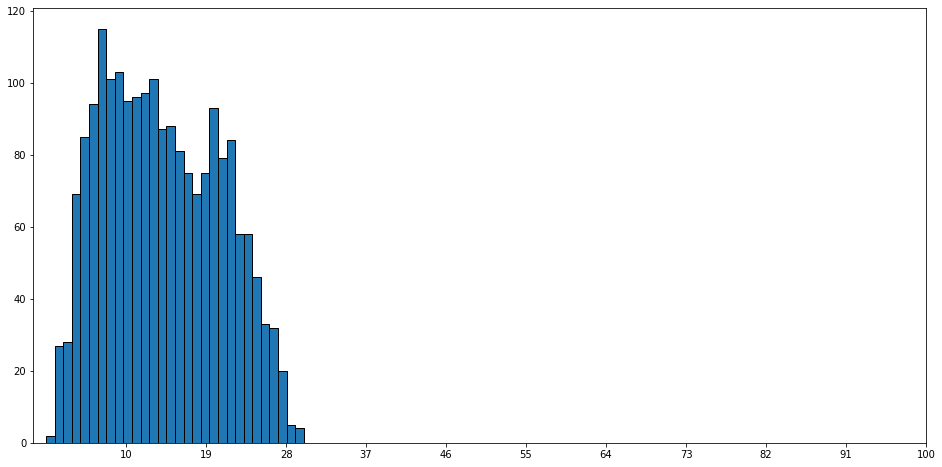

In [13]:
# token lengths distribution in the dataset
token_lengths = [len(i.split()) for i in dataframe["tweet"]]
plt.figure(figsize=(16,8))
plt.hist(token_lengths,bins = 30,edgecolor="black")
plt.xticks(ticks = np.linspace(10,100,11))
plt.show()
dataframe["token_length"] = token_lengths

# Training and validation set
We can also consider token length

In [14]:
# token_length 128, seems a good fit for data

# split training and validation data
train_df, val_df = train_test_split(dataframe, test_size= 0.20, stratify= dataframe["class"], random_state = 40)

# val_df,   test_df   = train_test_split(temp_df, test_size= 0.80, stratify= temp_df["class"],random_state = 47)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop  = True)
# test_df  = test_df.reset_index(drop = True)


In [15]:
# load bertModel, bertTokenizer and freeze all layers
bertModel = AutoModel.from_pretrained("bert-base-uncased").to(device)
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
bertModel.trainable = False # freezing the weights

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_2148279/1538592670.py:2 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2148279/1538592670.py'                      │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:1902 in to                 │
│                                                                                                  │
│   1899 │   │   │   │   " model has already been set to the correct devices and casted to the co  │
│   1900 │   │   │   )                                                                             │
│   1901 │   │   else:                                                                             │
│ ❱ 1902 │   │   │   return super().to(*args, **kwargs)                                            │
│   1903 │                                                                                         │
│   1904 │   def half(self, *args):                                                                │
│   1905 │   │   # Checks if the model has been loaded in 8-bit                                    │
│                                                                                                  │
│ /home/naseem_fordham/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1152 in to    │
│                                                                                                  │
│   1149 │   │   │   │   │   │   │   non_blocking, memory_format=convert_to_format)                │
│   1150 │   │   │   return t.to(device, dtype if t.is_floating_point() or t.is_complex() else No  │
│   1151 │   │                                                                                     │
│ ❱ 1152 │   │   return self._apply(convert)                                                       │
│   1153 │                                                                                         │
│   1154 │   def register_full_backward_pre_hook(                                                  │
│   1155 │   │   self,                                                                             │
│                                                                                                  │
│ /home/naseem_fordham/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:802 in _apply │
│                                                                                                  │
│    799 │   def _apply(self, fn, recurse=True):                                                   │
│    800 │   │   if recurse:                                                                       │
│    801 │   │   │   for module in self.children():                                                │
│ ❱  802 │   │   │   │   module._apply(fn)                                                         │
│    803 │   │                                                                                     │
│    804 │   │   def compute_should_use_set_data(tensor, tensor_applied):                          │
│    805 │   │   │   if torch._has_compatible_shallow_copy_type(tensor, tensor_applied):           │
│                                                                                                  │
│ /home/naseem_fordham/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:802 in _apply │
│                                                                                                  │
│    799 │   def _apply(self, fn, recurse=True):                                                   │
│    800 │   │   if recurse:                                                                       │
│    801 │   │   │   for module in self.children():          

In [ ]:
#getting model total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(bertModel)


# Dataset creation for BERT Model

In [ ]:
from BERTdata_loader_noattention import BERTDataset
bert_dataset = BERTDataset(text=None, labels=None,  max_length=None, tokenizer=None, projection_dim=None)

# Paramters

Loading Weights

# Model Architecture

In [ ]:

class SpockModel(nn.Module):
    def __init__(self, MAX_LENGTH, PROJECTION_DIM, lambda_value):
        super(SpockModel, self).__init__()
        self.MAX_LENGTH = MAX_LENGTH
        self.PROJECTION_DIM = PROJECTION_DIM
        self.lambda_value = lambda_value
        self.VECTOR_DIM = 768

        # Layers
        self.bert_model = bertModel  # Assuming you have defined bertModel elsewhere
        self.offensive_embedding_layer = nn.Embedding(PROJECTION_DIM, self.VECTOR_DIM) # (None,PROJECTION_DIM,VECTOR_DIM)
        self.normal_embedding_layer = nn.Embedding(PROJECTION_DIM, self.VECTOR_DIM)   # (None,PROJECTION_DIM,VECTOR_DIM)

        self.hidden1 = nn.Linear(2 * self.PROJECTION_DIM, 612)
        self.dropout1=nn.Dropout(0.5)
        self.hidden2 = nn.Linear(612, 256)
        self.dropout2=nn.Dropout(0.5)
        self.hidden3 = nn.Linear(256, 64)
        self.dropout3=nn.Dropout(0.5)
        self.hidden4 = nn.Linear(64, 30)
        self.dropout4=nn.Dropout(0.5)
        self.hidden5 = nn.Linear(30, 10)
        self.classification_layer = nn.Linear(10, 1)
        
        

        # Loss Functions
        self.cosine_loss = CosineSimilarityLoss(name='cosine_loss')
        self.intra_loss = IntraClassLoss(name='intra_loss')
        self.bce_loss = BinaryCrossEntropyLoss(name='attention_loss')
        # self.loss_values = LossValues()


    def forward(self, ids, mks, projection_space):
        input_sentence = self.bert_model(ids, attention_mask=mks)[0].to(device)   #(None, Max_Len,VECTOR_DIM)
        # print(input_sentence.shape)
        offensive_embedding_np = self.offensive_embedding_layer(projection_space)  # (None,PROJECTION_DIM,VECTOR_DIM)
        normal_embedding_np = self.normal_embedding_layer(projection_space)        # (None,PROJECTION_DIM,VECTOR_DIM)
        # print(normal_embedding_np.shape)
        offensive_embedding = offensive_embedding_np.permute(0, 2, 1)              #(None,PROJECTION_DIM, VECTOR_DIM) --> (None,VECTOR_DIM,PROJECTION_DIM)
        normal_embedding = normal_embedding_np.permute(0, 2, 1)
        # print(normal_embedding.shape)

        offensive_cosine = self.cosine_similarity_projected(input_sentence, offensive_embedding) #  (None, Max_Len,VECTOR_DIM). (None,VECTOR_DIM,PROJECTION_DIM) -->((None, Max_Len, Projection)
        normal_cosine = self.cosine_similarity_projected(input_sentence, normal_embedding)
        # print(normal_cosine.shape)

        
        offensive_cosine_nopads = self.remove_padsV2(offensive_cosine, ids)
        normal_cosine_nopads = self.remove_padsV2(normal_cosine, ids)

        
        
        merged = self.merge_functionV2(offensive_cosine_nopads, normal_cosine_nopads)
        merged = merged.view(-1, 2 * self.PROJECTION_DIM)

        hidden1 = torch.tanh(self.hidden1(merged))
        hidden1_output = self.dropout1(hidden1)
        
        hidden2 = torch.tanh(self.hidden2(hidden1_output))
        hidden2_output=self.dropout1(hidden2)
        
        hidden3 = torch.tanh(self.hidden3(hidden2_output))
        hidden3_output=self.dropout1(hidden3)
        
        hidden4 = torch.tanh(self.hidden4(hidden3_output))
        hidden4_output=self.dropout1(hidden4)

        
        hidden5 = torch.tanh(self.hidden5(hidden4_output))
        hidden5_output=self.dropout1(hidden5)


        predictions = self.classification_layer(hidden5_output)
        

        # # Losses
        offensive_normal_loss = self.cosine_loss(torch.mean(offensive_cosine, dim=1), torch.mean(normal_cosine, dim=1))
        toxic_intra_loss = self.intra_loss(offensive_cosine)
        non_toxic_intra_loss = self.intra_loss(normal_cosine)

        # Total Loss
        # + self.lambda_value * bce_loss1
        loss = offensive_normal_loss + toxic_intra_loss + non_toxic_intra_loss 
        
        
        return predictions,loss,offensive_normal_loss, toxic_intra_loss, non_toxic_intra_loss
    
    
    def cosine_similarity_projected(self, x, w):
        dp = torch.matmul(x, w)
        x_mag = torch.norm(x, dim=2, keepdim=True)
        w_mag = torch.norm(w, dim=1, keepdim=True)
        cosine = dp / (x_mag * w_mag)
        return cosine
    


    def merge_functionV2(self, negative, normal):
        negative_max = torch.max(negative, dim=1, keepdim=True)[0]
        normal_max = torch.max(normal, dim=1, keepdim=True)[0]
        return torch.cat([negative_max, normal_max], dim=-1)
    
    def remove_padsV2(self, vects, ids):
        # masks = ids != 0
        masks = (ids != 101) & (ids != 102)
        masks = masks.unsqueeze(-1).float()
        masked_embeddings = vects * masks

        # print(masked_embeddings.shape)
        return masked_embeddings


    






# Model Training and Saving 

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred)[0].sum().item() # torch.eq() calculates where two tensors are equal
    # print(torch.eq(y_true, y_pred)[0])
    acc = (correct / len(y_pred)) * 100 
    return acc

In [68]:
MAX_LEN = 20
BATCH_SIZE=8
lambda_value, w1, w2=4,1,1
learning_rate=1e-5
num_epochs=5
PROJECTION_DIM=15


from tqdm import tqdm
train_dataloader,val_dataloader = bert_dataset.dataprep(train_df, val_df, tokenizer, MAX_LEN, BATCH_SIZE,PROJECTION_DIM)


# Define loss function and optimizer
# criterion = torch.nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()

space_model = SpockModel(MAX_LEN, PROJECTION_DIM, lambda_value).to(device)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

optimizer = optim.SGD(space_model.parameters(), lr=learning_rate,momentum=0.5)



from tqdm import tqdm  # Import tqdm


# Training loop
for epoch in range(num_epochs):
    space_model.train()  # Set the model to train mode
    t_running_loss = 0.0
    train_accuracy=0
    total_correct=0
    correct_val=0
    
    train_loss = 0.0
    train_offensive_normal_loss = 0.0
    train_toxic_intra_loss = 0.0
    train_non_toxic_intra_loss = 0.0
    
    # Wrap your dataloader with tqdm
    with tqdm(train_dataloader, desc=f'Epoch {epoch+1}', unit='batch') as train_bar:
        for batch_idx, batch in enumerate(train_bar):
            # print(batch_idx)
            
            optimizer.zero_grad()
            
            # Move tensors to the same device as the model
            ids = batch['input_ids'].to(device)
            mks = batch['attention_masks'].to(device)
            labels = batch['label'].to(device)
            space = batch['space'].to(device)
            
            # Forward pass
            y_logits, loss, off_normal_loss, train_toxic_intra_loss, train_non_toxic_intra_loss = space_model.to(device)(ids, mks, space)
     
            labels = labels.float()
            
            y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels
            # print(y_pred.view(-1,1))


            # 2. Calculate loss/accuracy
            bce_loss = criterion(y_pred.squeeze(), labels)
            
                       # L1 regularization
#             l2_lambda = 0.01  # Adjust this value as needed
#             # l1_reg = torch.tensor(0., device=device)
#             # for param in model.parameters():
#             #     l1_reg += torch.norm(param, 1)
#             # loss += l1_lambda * l1_reg
            
            
#             l2_reg = torch.tensor(0., device=device)
#             for param in model.parameters():
#                 l2_reg += torch.norm(param, p=2)  # Compute the L2 norm of the parameters

#             loss += l2_lambda * l2_reg 
            loss+=bce_loss

            train_accuracy = accuracy_fn(y_true=labels, 
                              y_pred=y_pred) # for traing wer need  batch accuracy it need to be imrpving for each batch and following epoch
            
            loss.backward()
            optimizer.step()

            t_running_loss += loss.item()

            train_bar.set_postfix(loss=t_running_loss / (batch_idx + 1),accuracy=train_accuracy)



      
        # print(f'Epoch {epoch+1}, Training_Loss: {running_loss:.5f}, Train_Accuracy: {train_accuracy:.2f}')

    # Validation loop
    space_model.eval()  # Set the model to evaluation mode
    loss=0
    val_loss = 0.0
    total_predictions = 0
    v_running_loss=0
    total=0
    validation_accuracy=0

    
    val_loss = 0.0
    val_offensive_normal_loss = 0.0
    val_toxic_intra_loss = 0.0
    val_non_toxic_intra_loss = 0.0

    
    with tqdm(val_dataloader, desc=f'Epoch {epoch+1} ', unit='batch') as val_bar:
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_bar):
                # Move tensors to the same device as the model
                ids = batch['input_ids'].to(device)
                mks = batch['attention_masks'].to(device)
                labels = batch['label'].to(device)
                space = batch['space'].to(device)

                # Forward pass
                y_logits,val_loss, val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss = space_model(ids, mks, space)
                y_pred = torch.round(torch.sigmoid(y_logits))

                # Calculate loss
                bce_loss = criterion(y_pred.squeeze(), labels.float())
                val_loss += bce_loss

                # Calculate accuracy
                
                validation_accuracy += accuracy_fn(y_true=labels, 
                              y_pred=y_pred)
                # print(validation_accuracy)
                
                correct_predictions = torch.eq(y_pred, labels.view_as(y_pred)).sum().item()
                # print(correct_predictions)
                total_predictions += labels.size(0)
                correct_val += correct_predictions
                v_running_loss=val_loss.item()

                # Update progress bar
                val_bar.set_postfix(loss=v_running_loss ,accuracy=validation_accuracy/(batch_idx + 1))





        print(f'Epoch {epoch+1}, Training_Loss: {t_running_loss/len(train_dataloader):.5f}, Train_Accuracy: {train_accuracy:.2f}')
        print(f'Validation_Loss: {val_loss:.6f},  Val_Accuracy: {validation_accuracy/len(val_dataloader):.4f}')



import gc
model = None
gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
print_gpu_utilization(device_id)
torch.cuda.empty_cache()
free_gpu_cache(device_id)

Epoch 1 : 100%|███| 200/200 [00:01<00:00, 116.75batch/s, accuracy=50, loss=15.7]


Epoch 1, Training_Loss: 21.88676, Train_Accuracy: 87.50
Validation_Loss: 15.738882,  Val_Accuracy: 50.0000


Epoch 2 : 100%|███| 200/200 [00:01<00:00, 118.71batch/s, accuracy=50, loss=14.1]


Epoch 2, Training_Loss: 16.03653, Train_Accuracy: 37.50
Validation_Loss: 14.122125,  Val_Accuracy: 50.0000


Epoch 3 : 100%|███| 200/200 [00:01<00:00, 119.62batch/s, accuracy=50, loss=13.4]


Epoch 3, Training_Loss: 14.69324, Train_Accuracy: 62.50
Validation_Loss: 13.400448,  Val_Accuracy: 50.0000


Epoch 4 : 100%|███| 200/200 [00:01<00:00, 119.38batch/s, accuracy=50, loss=12.8]


Epoch 4, Training_Loss: 13.99099, Train_Accuracy: 12.50
Validation_Loss: 12.783786,  Val_Accuracy: 50.0000


Epoch 5 : 100%|███| 200/200 [00:01<00:00, 120.66batch/s, accuracy=50, loss=12.2]


Epoch 5, Training_Loss: 13.54005, Train_Accuracy: 87.50
Validation_Loss: 12.204401,  Val_Accuracy: 50.0000
GPU memory occupied: 14926 MB.
Initial GPU Usage
GPU memory occupied: 14926 MB.
GPU Usage after emptying the cache
GPU memory occupied: 14926 MB.


In [16]:
import gc
model = None
gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
print_gpu_utilization(device_id)
torch.cuda.empty_cache()
free_gpu_cache(device_id)

GPU memory occupied: 24534 MB.
Initial GPU Usage
GPU memory occupied: 24534 MB.
GPU Usage after emptying the cache
GPU memory occupied: 24534 MB.


In [90]:
def train_epoch(model, train_dataloader, optimizer):
    model.train()
    train_loss = 0.0
    train_offensive_normal_loss = 0.0
    train_toxic_intra_loss = 0.0
    train_non_toxic_intra_loss = 0.0

    with tqdm(train_dataloader, desc=f'Epoch {epoch+1} ', unit='batch') as train_bar:
    # with tqdm(total=total_steps, desc=f'Epoch {epoch+1} ', unit='step') as train_bar:

        for batch_idx,batch in enumerate(train_bar):
                 

        
            # loss=0
            ids = batch['input_ids'].to(device)
            mks = batch['attention_masks'].to(device)
            space = batch['space'].to(device)
            labels = batch['label'].to(device)
            
          

            optimizer.zero_grad()

            y_logits, loss, off_normal_loss, toxic_intra_loss, non_toxic_intra_loss = model(ids, mks, space)
            
            predictions = torch.round(torch.sigmoid(y_logits))

            # Compute Binary Cross-Entropy Loss
            # bce_loss = torch.nn.BCELoss()(predictions, labels.float())
            
            bce_loss = torch.nn.BCEWithLogitsLoss()(predictions.view(-1,1), labels.float().view(-1,1))

            # Total Loss
            loss += bce_loss
            train_accuracy = accuracy_fn(y_true=labels, 
                              y_pred=predictions)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_offensive_normal_loss += off_normal_loss.item()
            train_toxic_intra_loss += toxic_intra_loss.item()
            train_non_toxic_intra_loss += non_toxic_intra_loss.item()
            
            train_bar.set_postfix(loss=train_loss / (batch_idx + 1),accuracy=train_accuracy)


        return train_loss, predictions, labels, train_offensive_normal_loss, train_toxic_intra_loss, train_non_toxic_intra_loss


def evaluate(model, val_dataloader):
    model.eval()
    val_loss = 0.0
    val_offensive_normal_loss = 0.0
    val_toxic_intra_loss = 0.0
    val_non_toxic_intra_loss = 0.0

    with tqdm(val_dataloader, desc=f'Epoch {epoch+1} ', unit='batch') as val_bar:

        with torch.no_grad():
            for batch_idx, batch in enumerate(val_bar):
                ids = batch['input_ids'].to(device)
                mks = batch['attention_masks'].to(device)
                space = batch['space'].to(device)
                labels = batch['label'].to(device)

                y_logits, loss, off_normal_loss, toxic_intra_loss, non_toxic_intra_loss = model(ids, mks, space)

                # Compute Binary Cross-Entropy Loss
                # bce_loss = torch.nn.BCELoss()(predictions, labels.float())
                
                predictions = torch.round(torch.sigmoid(y_logits))

                # Compute Binary Cross-Entropy Loss
                # bce_loss = torch.nn.BCELoss()(predictions, labels.float())

                bce_loss = torch.nn.BCEWithLogitsLoss()(predictions.view(-1,1), labels.float().view(-1,1))

                # Total Loss
                loss += bce_loss
                val_accuracy = accuracy_fn(y_true=labels, 
                                  y_pred=predictions)



                # Total Loss
                loss += bce_loss

                val_loss += loss.item()
                val_offensive_normal_loss += off_normal_loss.item()
                val_toxic_intra_loss += toxic_intra_loss.item()
                val_non_toxic_intra_loss += non_toxic_intra_loss.item()
                
                val_bar.set_postfix(loss=val_loss / (batch_idx + 1),accuracy=val_accuracy)
            
     

    return val_loss, predictions, labels, val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss


In [91]:
# def eval(f):
#     def wrapper(model, *args, **kwargs):
#         model.eval()
#         return f(model, *args, **kwargs)
#     return wrapper

# def train(f):
#     def wrapper(model, *args, **kwargs):
#         model.train()
#         return f(model, *args, **kwargs)
#     return wrapper

# # train_dataloader,val_dataloader=dataprep(3)
# @train
# def train_epoch(model, train_dataloader, optimizer):
#     train_loss = 0.0
#     train_preds = []
#     train_labels = []

#     for step, batch in enumerate(train_dataloader):
#         # print(step)
#         # if step==1:
#         # loss=0
        
        
#         input_ids = batch['input_ids'].to(device)
#         attention_masks = batch['attention_masks'].to(device)
#         space = batch['space'].to(device)
#         labels = batch['label'].to(device)
#         outputs = model(input_ids, attention_masks, space) # (B, Seq_Len, 2)
#         preds,loss,train_offensive_normal_loss,train_toxic_intra_loss, train_non_toxic_intra_loss= outputs
        
#         labels = labels.view(-1, 1).float()
        
#         bce_loss = nn.BCEWithLogitsLoss()(preds.view(-1,1), labels.float())
#         loss += bce_loss
        
#         train_preds += preds.detach().tolist()
#         # print(preds)
#         train_labels += [l.item() for l in labels]

#         optimizer.zero_grad()

#         loss.backward()
                        
#         optimizer.step()

#         train_loss += loss.item()
#         # else:
#         #     break
#     return train_loss, train_preds, train_labels,train_offensive_normal_loss,train_toxic_intra_loss, train_non_toxic_intra_loss

# @eval
# # '''PLOT HISTIOGRAM TO SEE THE SCORE DISTRIBUTION'''

# def eval_epoch(model, val_dataloader):
#     val_loss = 0.0
#     val_preds = []
#     val_labels = []

#     with torch.no_grad():

#         for step, batch in enumerate(val_dataloader):
#             # if step==1:
#             input_ids = batch['input_ids'].to(device)
#             attention_masks = batch['attention_masks'].to(device)
#             space = batch['space'].to(device)
#             labels = batch['label']

#             outputs = model(input_ids, attention_masks, space) # (B, Seq_Len, 2)

#             # loss, logits = outputs.loss, outputs.logits
#             preds,loss,val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss = outputs
#             loss=torch.mean(loss)
#             # print(preds.dtype)


#             # probs = F.softmax(logits, dim=-1)

#             # pred = torch.argmax(probs, dim=-1) # (B)
#             val_preds += preds.detach().tolist()
#             val_labels += [l.item() for l in labels]
#             # print(val_labels,val_preds)
#             val_loss += loss.item()
#         # else:
#         #     continue

               
    # return val_loss, val_preds, val_labels,val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss

In [92]:
#Metrices
#assert take afucntion to take a conditon 


def training(model, train_data, val_data, config):
    model = model
    
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9)

    # optimizer = torch.optim.Adam(
    #     params=model.parameters(),
    #     lr=config['lr'],
        # weight_decay=config['weight_decay']
    # )

    num_train_steps = int(len(train_data) / config['batch_size'] * config['epochs'])
    # num_train_steps=2

    print(f'Train steps: {num_train_steps}')


    history = {
        'train_losses': [],
        'val_losses': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': [],
        'train_precision': [],
        'val_precision': [],
        'train_recall': [],
        'val_recall': [],
        'train_offensive_normal_loss': [],
        'train_toxic_intra_loss': [],
        'train_non_toxic_intra_loss': [],
        'val_offensive_normal_loss': [],
        'val_toxic_intra_loss': [],
        'val_non_toxic_intra_loss': [],
    }
    # Inside the training loop
    for epoch_num in range(config['epochs']):
        print(f'Epoch: {epoch_num + 1}')

        # Train stage
        train_loss, train_preds, train_labels,train_offensive_normal_loss,train_toxic_intra_loss, train_non_toxic_intra_loss = train_epoch(model, train_dataloader, optimizer)

        # Eval stage
        val_loss, val_preds, val_labels,val_offensive_normal_loss, val_toxic_intra_loss, val_non_toxic_intra_loss= evaluate(model, val_dataloader)


        train_preds_tensor = torch.tensor(train_preds).detach()
        val_preds_tensor = torch.tensor(val_preds).detach()
        
        
        train_preds_labels = train_preds_tensor.cpu().numpy()
        val_preds_labels = val_preds_tensor.cpu().numpy()
        
        val_labels=val_labels.cpu().numpy()
        train_labels=train_labels.cpu().numpy()
        

        # train_preds_labels = (train_preds_tensor >= 0.5).astype(int)
        # val_preds_labels = (val_preds_tensor >= 0.5).astype(int)
    
     
        # print(train_preds_tensor,train_labels)
    
    
        # Metrics calculation
        train_acc = accuracy_score(train_labels, train_preds_labels)
        val_acc = accuracy_score(val_labels, val_preds_labels)
        train_f1 = f1_score(train_labels, train_preds_labels, average='macro')
        val_f1 = f1_score(val_labels, val_preds_labels, average='macro')
        train_precision = precision_score(train_labels, train_preds_labels, average='weighted')
        val_precision = precision_score(val_labels, val_preds_labels, average='weighted')
        train_recall = recall_score(train_labels, train_preds_labels, average='weighted')
        val_recall = recall_score(val_labels, val_preds_labels, average='weighted')

        # Update history dictionary
        history['train_losses'].append(train_loss / len(train_dataloader))
        history['val_losses'].append(val_loss / len(val_dataloader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_precision'].append(train_precision)
        history['val_precision'].append(val_precision)
        history['train_recall'].append(train_recall)
        history['val_recall'].append(val_recall)
        
        history['train_offensive_normal_loss'].append(train_offensive_normal_loss)
        history['train_toxic_intra_loss'].append(train_toxic_intra_loss)
        history['train_non_toxic_intra_loss'].append(train_non_toxic_intra_loss)

        # Append validation loss values
        history['val_offensive_normal_loss'].append(val_offensive_normal_loss)
        history['val_toxic_intra_loss'].append(val_toxic_intra_loss)
        history['val_non_toxic_intra_loss'].append(val_non_toxic_intra_loss)



        
#         history['train_offensive_normal_loss'].append(train_offensive_normal_loss.detach().cpu().numpy())
#         history['train_toxic_intra_loss'].append(train_toxic_intra_loss.detach().cpu().numpy())
#         history['train_non_toxic_intra_loss'].append(train_non_toxic_intra_loss.detach().cpu().numpy())

#         # Append validation loss values
#         history['val_offensive_normal_loss'].append(val_offensive_normal_loss.detach().cpu().numpy())
#         history['val_toxic_intra_loss'].append(val_toxic_intra_loss.detach().cpu().numpy())
#         history['val_non_toxic_intra_loss'].append(val_non_toxic_intra_loss.detach().cpu().numpy())

        print()
        print(f'Train loss: {train_loss / len(train_dataloader)} | Val loss: {val_loss / len(val_dataloader)}')
        print(f'Train acc: {train_acc} | Val acc: {val_acc}')
        # print(f'Train f1: {train_f1} | Val f1: {val_f1}')
        # print(f'Train precision: {train_precision} | Val precision: {val_precision}')
        # print(f'Train recall: {train_recall} | Val recall: {val_recall}')
        
        

    # Free GPU cache if necessary
    free_gpu_cache(device_id)

    return history,val_preds, val_labels,train_preds


In [93]:
print_gpu_utilization(device_id)
torch.cuda.empty_cache()
free_gpu_cache(device_id)
MAX_LEN = 25
PROJECTION_DIM = 10
BATCH_SIZE=16
w1=0.5
w2=0.5
# VECTOR_DIM = 768
lambda_value = 0.2
NUM_EPOCHS = 25
LEARNING_RATE=0.001
MAX_GRAD_NORM=1000
# Initialize model

spock_model = SpockModel(MAX_LEN, PROJECTION_DIM, lambda_value)
# spock_model.to(device)


# train_dataloader,val_dataloader=dataprep(PROJECTION_DIM)
# Call the dataprep method on the object
train_dataloader,val_dataloader = bert_dataset.dataprep(train_df, val_df, tokenizer, MAX_LEN, BATCH_SIZE, PROJECTION_DIM)

config = {
    'epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'val_batch_size': BATCH_SIZE,
    
    'fp16': False,
    'lr': LEARNING_RATE,
}
history,val_preds, val_labels,train_preds = training(spock_model.to(device), train_dataloader, val_dataloader, config)
torch.cuda.empty_cache()

GPU memory occupied: 12080 MB.
Initial GPU Usage
GPU memory occupied: 12080 MB.
GPU Usage after emptying the cache
GPU memory occupied: 12080 MB.
Train steps: 15
Epoch: 1


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 71.97batch/s, accuracy=25, loss=11.4]



Train loss: 17.827467918395996 | Val loss: 11.439488728841146
Train acc: 0.4375 | Val acc: 0.25
Epoch: 2


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.79batch/s, accuracy=25, loss=10.9]



Train loss: 10.840694618225097 | Val loss: 10.865536371866861
Train acc: 0.375 | Val acc: 0.25
Epoch: 3


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.29batch/s, accuracy=25, loss=10.7]



Train loss: 10.472970962524414 | Val loss: 10.674363454182943
Train acc: 0.75 | Val acc: 0.25
Epoch: 4


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.75batch/s, accuracy=25, loss=10.6]



Train loss: 10.329650688171387 | Val loss: 10.57695198059082
Train acc: 0.875 | Val acc: 0.25
Epoch: 5


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.34batch/s, accuracy=25, loss=10.5]



Train loss: 10.243951416015625 | Val loss: 10.507955551147461
Train acc: 0.625 | Val acc: 0.25
Epoch: 6


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.18batch/s, accuracy=25, loss=10.5]



Train loss: 10.183181381225586 | Val loss: 10.458508809407553
Train acc: 0.5625 | Val acc: 0.25
Epoch: 7


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.33batch/s, accuracy=25, loss=10.4]



Train loss: 10.135570907592774 | Val loss: 10.420579274495443
Train acc: 0.5 | Val acc: 0.25
Epoch: 8


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.27batch/s, accuracy=25, loss=10.4]



Train loss: 10.100756072998047 | Val loss: 10.38928476969401
Train acc: 0.5625 | Val acc: 0.25
Epoch: 9


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.43batch/s, accuracy=25, loss=10.4]



Train loss: 10.06883373260498 | Val loss: 10.362441380818685
Train acc: 0.375 | Val acc: 0.25
Epoch: 10


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.06batch/s, accuracy=25, loss=10.3]



Train loss: 10.042207336425781 | Val loss: 10.338727951049805
Train acc: 0.5 | Val acc: 0.25
Epoch: 11


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.78batch/s, accuracy=25, loss=10.3]



Train loss: 10.016894340515137 | Val loss: 10.317357381184896
Train acc: 0.4375 | Val acc: 0.25
Epoch: 12


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 93.96batch/s, accuracy=25, loss=10.3]



Train loss: 9.996460151672363 | Val loss: 10.297920227050781
Train acc: 0.5625 | Val acc: 0.25
Epoch: 13


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.36batch/s, accuracy=25, loss=10.3]



Train loss: 9.977450752258301 | Val loss: 10.28005345662435
Train acc: 0.6875 | Val acc: 0.25
Epoch: 14


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 93.69batch/s, accuracy=25, loss=10.3]



Train loss: 9.955750846862793 | Val loss: 10.263427734375
Train acc: 0.4375 | Val acc: 0.25
Epoch: 15


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.00batch/s, accuracy=25, loss=10.2]



Train loss: 9.939947509765625 | Val loss: 10.247916539510092
Train acc: 0.25 | Val acc: 0.25
Epoch: 16


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.96batch/s, accuracy=25, loss=10.2]



Train loss: 9.922895050048828 | Val loss: 10.233355204264322
Train acc: 0.5 | Val acc: 0.25
Epoch: 17


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.17batch/s, accuracy=25, loss=10.2]



Train loss: 9.90887279510498 | Val loss: 10.21958096822103
Train acc: 0.625 | Val acc: 0.25
Epoch: 18


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.21batch/s, accuracy=25, loss=10.2]



Train loss: 9.891897392272949 | Val loss: 10.206549962361654
Train acc: 0.5625 | Val acc: 0.25
Epoch: 19


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.57batch/s, accuracy=25, loss=10.2]



Train loss: 9.8788272857666 | Val loss: 10.194138844807943
Train acc: 0.5 | Val acc: 0.25
Epoch: 20


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 95.05batch/s, accuracy=25, loss=10.2]



Train loss: 9.865978050231934 | Val loss: 10.182265599568685
Train acc: 0.625 | Val acc: 0.25
Epoch: 21


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.95batch/s, accuracy=25, loss=10.2]



Train loss: 9.854580688476563 | Val loss: 10.170839309692383
Train acc: 0.375 | Val acc: 0.25
Epoch: 22


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.29batch/s, accuracy=25, loss=10.2]



Train loss: 9.841850471496581 | Val loss: 10.159852345784506
Train acc: 0.3125 | Val acc: 0.25
Epoch: 23


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.78batch/s, accuracy=25, loss=10.1]



Train loss: 9.830830574035645 | Val loss: 10.149296442667643
Train acc: 0.4375 | Val acc: 0.25
Epoch: 24


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.78batch/s, accuracy=25, loss=10.1]



Train loss: 9.81615924835205 | Val loss: 10.139093399047852
Train acc: 0.375 | Val acc: 0.25
Epoch: 25


Epoch 5 : 100%|████████| 3/3 [00:00<00:00, 94.68batch/s, accuracy=25, loss=10.1]



Train loss: 9.806823921203613 | Val loss: 10.129199345906576
Train acc: 0.4375 | Val acc: 0.25
Initial GPU Usage
GPU memory occupied: 12470 MB.
GPU Usage after emptying the cache
GPU memory occupied: 12450 MB.


In [94]:

# MAX_LEN = 30
# PROJECTION_DIM = 30
# BATCH_SIZE=20
# LEARNING_RATE=0.01
# w1=0.5
# w2=0.5
# MAX_GRAD_NORM=1000
# VECTOR_DIM = 768
# lambda_value = 0.2
# NUM_EPOCHS = 20

# # Initialize model
# spock_model2 = SpockModel(MAX_LEN, PROJECTION_DIM, lambda_value)
# # spock_model.to(device)


# # train_dataloader,val_dataloader=dataprep(PROJECTION_DIM)
# # Call the dataprep method on the object
# train_dataloader,val_dataloader = bert_dataset.dataprep(train_df, val_df, tokenizer, MAX_LEN, BATCH_SIZE, PROJECTION_DIM)

# config = {
#     'epochs': NUM_EPOCHS,
#     'batch_size': BATCH_SIZE,
#     'val_batch_size': BATCH_SIZE,
    
#     # 'gradient_accumulation_steps': 5, 
    
#     # ''''gradient_accumulation_steps': 1: Gradient accumulation is a technique used for training 
#     # when the effective batch size is larger than the available memory. It accumulates gradients over multiple batches before
#     # updating the model parameters.'''
    
#     'fp16': False,
#     'lr': LEARNING_RATE,
#     # 'max_grad_norm': MAX_GRAD_NORM,
#     # 'weight_decay': 0,
# }
# history,val_preds, val_labels,train_preds = training(spock_model2.to(device), train_dataloader, val_dataloader, config)
# torch.cuda.empty_cache()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(history, do_val=True):
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Losses
    axs[0, 0].plot(history['train_losses'], label='Train Loss')
    if do_val:
        axs[0, 0].plot(history['val_losses'], label='Validation Loss')
    axs[0, 0].set_title('Train / Validation Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # Accuracy
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy')
    if do_val:
        axs[0, 1].plot(history['val_acc'], label='Validation Accuracy')
    axs[0, 1].set_title('Train / Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # F1 Score
    # axs[1, 0].plot(history['train_f1'], label='Train F1 Score')
    
    axs[1, 0].plot(history['train_offensive_normal_loss'], label='train_offensive_normal_loss')
    if do_val:
        axs[1, 0].plot(history['val_offensive_normal_loss'], label='val_offensive_normal_loss')

    axs[1, 0].set_title('Train / Validation offensive_normal_loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('offensive_normal_loss')
    axs[1, 0].legend()

    # Precision
    
    axs[1,1].plot(history['train_toxic_intra_loss'], label='train_toxic_intra_loss')

    if do_val:
        axs[1,1].plot(history['train_non_toxic_intra_loss'], label='train_non_toxic_intra_loss')
    # axs[1, 1].plot(history['train_precision'], label='Train Precision')
    # if do_val:
    #     axs[1, 1].plot(history['val_precision'], label='Validation Precision')
    axs[1, 1].set_title('Toxic/ Non_Toxix intra_loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Intra_loss')
    axs[1, 1].legend()
    

    
    plt.subplots_adjust(wspace=5, hspace=0.5)


    plt.tight_layout()
    plt.show()

# Example usage:
plot_results(history)

# learn oythin debggung
#ASSERT FUNCTION
#USE ATMOST 100 LABELS
#PLOT MIRE SENSISBLE

In [ ]:
# Training loop
# Set up hyperparameters
MAX_LENGTH = 30
BATCH_SIZE = 16
PROJECTION_DIM = 30
VECTOR_DIM = 768
lambda_value = 2
EPOCHS = 20
PROJECTION_DIM = 10  # You redefined PROJECTION_DIM here, it might not be necessary


# Initialize model
spock_model1 = SpockModel(MAX_LENGTH, PROJECTION_DIM, lambda_value)

# Set up loss function and optimizer
criterion = nn.BCELoss()  # Define your loss function
optimizer = optim.Adam(spock_model1.parameters(), lr=0.001)  # Define your optimizer
train_ds,val_ds=dataprep(PROJECTION_DIM)



for epoch in range(EPOCHS):
    running_loss = 0.0

    for i,data in enumerate(train_ds):
        # Get the inputs, attention masks, space, attention score, and labels from the dictionary
        input_ids = data['input_ids']
        attention_masks = data['attention_masks']
        space = data['space']
        labels = data['label']
        
        
        # print(input_ids.shape,attention_masks.shape,space.shape,attention_score.shape)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # print('ok')

        # Forward pass\ids, mks, projection_space, attention_score
        outputs, loss = spock_model1(input_ids, attention_masks, space)
        # print('ok3')

        # Calculate loss
        
        labels=labels.view(-1,1)
        # print(outputs.dtype,labels.dtype)
        # print(outputs.shape,labels.shape)
        labels = labels.float()
    
        loss = criterion(outputs, labels)
        # print('ok')

        # Backward pass and optimize




        loss.backward()
        optimizer.step()
        # print('ok')

        # Print statistics
        running_loss += loss.item()
        if i % 5== 1999:  # Print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

    # Log loss to TensorBoard
    writer.add_scalar("training_loss", running_loss, epoch)

print("Finished Training")


# Initiazliz the tensorboard to visualize the graph

In [ ]:
#1st laod the teansorbaord before tarining
# %load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# MAX_LENGTH = 30
# BATCH_SIZE = 16
# PROJECTION_DIM =30
# VECTOR_DIM = 768
# 
# spock_model1= spock_model(MAX_LENGTH, PROJECTION_DIM)
# spock_model1.summary()\
# tf.keras.backend.clear_session()
# print("TensorFlow version: ", tf.__version__)

# # Load the TensorBoard notebook extension.
# %load_ext tensorboard
# %reload_ext tensorboard

In [ ]:
# !ps aux | grep tensorboard
# # !kill 146651
# !pkill -f tensorboard


In [ ]:
# tf.profiler.experimental.stop()

# Validating Model and Confusion Matrix

In [ ]:
MAX_LENGTH = 30
BATCH_SIZE = 32
# PROJECTION_DIM =30
VECTOR_DIM = 768
lambda_value=2

In [ ]:
# ##incase the port is already using, we have to kill it forst
# !lsof -i :6006
# !kill 148692



In [ ]:
#laod the tensor board with passing the base path. Note incase of runing on VPN, I need to 
# http://192.168.1.206:8000/user/naseem_fordham/proxy/6006/ where 6006 is the local host port
# %tensorboard --logdir $BASE_PATH



In [ ]:
#accuracy plots
from matplotlib import pyplot as plt


def plot(history,path):
    # Create a new figure for the combined plot
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot accuracy on the first subplot
    axs[0].plot(history['accuracy'])
    axs[0].plot(history['val_accuracy'])
    axs[0].set_title('Model Accuracy', fontsize=12)
    axs[0].set_ylim(0, 1, 0.1)
    axs[0].set_ylabel('Accuracy', fontsize=12)
    axs[0].set_xlabel('Epoch', fontsize=12)
    axs[0].legend(['Train', 'Validation'], loc='upper left', fontsize=12)
    
    # Plot loss on the second subplot


    axs[1].plot(history['loss'])
    axs[1].plot(history['val_loss'])
    axs[1].plot(history['Interspace'])
    axs[1].plot(history['ToxicIntra_Loss'])
    axs[1].plot(history['Non_toxicIntra_Loss'])
    axs[1].plot(history['Attention_Loss'])
    
 

    axs[1].set_title('Model Loss', fontsize=12)
    axs[1].set_ylim(0, 15, 1)
    axs[1].set_ylabel('Loss', fontsize=12)
    axs[1].set_xlabel('Epoch', fontsize=12)
    # axs[1].legend(['Train', 'Validation','offensive_normal_loss','posStdDevLoss','norStdDevLoss'], loc='upper left', fontsize=12)
    # axs[1].legend(['Train', 'Validation','offensive_normal_loss'], loc='upper left', fontsize=12)
    
    axs[1].legend(['Train', 'Validation','Interspace','ToxicIntra_Loss','Non_toxicIntra_Loss','Attention_loss'], loc='upper left', fontsize=12)
    # axs[1].legend(['Train', 'Validation','interspace'], loc='upper left', fontsize=12)

    # axs[1].legend(['Train', 'Validation','ToxicIntra_Loss','Non_toxicIntra_Loss','interspace'], loc='upper left', fontsize=12)

   

    
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.3)

    # Save the combined plot as a single image
    plt.savefig(path, dpi=100)

# Model laoding from directory


In [ ]:
# convert sigmoid outputs to labels
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import numpy as np

def predictionLabels(i):
    return np.where(i < 0.5, 0.0, 1.0)

    
    
    # return np.argmax(i, axis=1)

pattern = r"_([0-9]+)$"


getLabels = np.vectorize(predictionLabels)
# predictions = model.predict(test_ds)
# predictedLabels = getLabels(predictions)

BASE_PATH = f"/home/naseem_fordham/Spock-paper/Spock_Hateoffensive/"

accuracy=[]
# Iterate over subdirectories
for folder_name in os.listdir(BASE_PATH):
    print(folder_name)
    folder_path = os.path.join(BASE_PATH, folder_name)

    if os.path.isdir(folder_path):
        match = re.search(pattern, folder_name)
        if match:
            model_number = match.group(1)
            print(folder_path)
            spock_model2 = spock_model(MAX_LENGTH, int(model_number),lambda_value)
            model_filename = os.path.join(folder_path, f"CS_{model_number}.h5")
            print(model_filename)

            if os.path.exists(model_filename):
                spock_model2.load_weights(model_filename)
                
                history=np.load(f"{folder_path}/training_history{model_number}.pkl",allow_pickle=True)
                accuracy.append(history['val_accuracy'][-1])
                
                # print(f"Loaded model from {model_filename,model_number}")
                train_ds, val_ds = dataprep(int(model_number))

                # Calculate the confusion matrix
                predictions = spock_model2.predict(val_ds)
                predictedLabels = predictionLabels(predictions)
                cm = confusion_matrix(val_df['class'].values, predictedLabels)

                # Calculate the confusion matrix as percentages
                cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

                # Create a ConfusionMatrixDisplay for the percentage confusion matrix
                disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Toxic', 'Non-Toxic'])

                # Calculate the classification report
                clf_report = classification_report(val_df['class'],
                                                   predictedLabels,
                                                   target_names=['Toxic', 'Non-Toxic'],
                                                   output_dict=True)


                # Create a new figure for the combined plot
                fig, axs = plt.subplots(1, 2, figsize=(12, 5))

                # Plot the confusion matrix as percentages on the left
                disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=axs[0])
                axs[0].set_title(f'Confusion Matrix of CS_{model_number}')

                # Plot the classification report as a heatmap on the right
                sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=axs[1])
                axs[1].set_title(f'Classification Report of CS_{model_number}')

                # Adjust spacing between subplots
                plt.subplots_adjust(wspace=0.5)
                
                
                           # Save the combined plot as a single image
                plt.savefig(f'{folder_path}/combined_CS_{model_number}.png')
                plot(history,f'{folder_path}/Acc_loss{model_number}.png')



            


In [ ]:
history.keys()

# Load Weights and Model Evaluation

In [ ]:
# UNCOMMENT THIS CELL AFTER MODEL TRAINING

# save model history

with open(f"{BASE_PATH}/training_historyV4.pkl","wb") as hist:
  pickle.dump(history.history,hist)

# history=np.save(f"/home/naseem_fordham/Hate_Xplain/history/C_loss_history_{PROJECTION_DIM}.npy",history.history)

In [ ]:
BASE_PATH = "/home/naseem_fordham/Spock-paper/Spock_HateXplain"
model.load_weights(f"{BASE_PATH}/test3.h5")
history=np.load(f"{BASE_PATH}/training_historyV4.pkl",allow_pickle=True)

In [ ]:
# # BASE_PATH='/home/naseem_fordham/Spock-paper/'
# model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# history=np.load(f"{BASE_PATH}/training_historyV4.pkl",allow_pickle=True)
# history
# import pickle

# with open('/home/naseem_fordham/Spock-paper/Random_w/Model/training_historyV4.pkl', 'rb') as f:
#     loaded_data = np.load(f,allow_pickle=True)


In [ ]:
# prepare test data for evaluation:
test_gen   = dataset(test_df["tweet"].values,test_df["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer, projection_dim=PROJECTION_DIM, val = True)
test_ds = tf.data.Dataset.from_generator(test_gen,
                                            output_signature = 
                                           ({"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [ ]:
# convert sigmoid outputs to labels
def predictionLabels(i):
     return np.argmax(i, axis=1)

  # if i < 0.5:
  #   return 0.0
  # else:
  #   return 1.0

# getLabels = np.vectorize(predictionLabels)
predictions = model.predict(test_ds)
predictedLabels = predictionLabels(predictions)

In [ ]:
predictedLabels

In [ ]:
np.argmax(predictions, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
predictedLabels = predictionLabels(predictions)

confusion_matrix(test_df['class'].values, predictedLabels)
ConfusionMatrixDisplay.from_predictions(test_df['class'].values, predictedLabels)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(test_df['class'].values, predictedLabels)

# Calculate the confusion matrix as percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a ConfusionMatrixDisplay for the percentage confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['0','1','2'])  # You should define class_labels

# Plot the confusion matrix as percentages
disp.plot(cmap=plt.cm.Blues, values_format=".2f")
plt.show()


In [ ]:
import seaborn as sns
# print(classification_report(y_test, predictedLabels))
clf_report = classification_report(test_df['class'],
                                   predictedLabels,
                                   
                                   target_names=[0,1,2],
                                   output_dict=True)


sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

plt.figure(figsize=(12,8))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy',fontdict = {'fontsize' : 12})
plt.ylim(0,1,0.1)

plt.ylabel('accuracy',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',{'fontsize' : 12})
# plt.ylim(0, ,0.05)
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation accuracy')
# display(plt.show())
# plt.show()

# plt.savefig(f"/home/naseem_fordham/Hate_Xplain//acc.png",dpi=300)
# plt.savefig(f"/home/naseem_fordham/Hate_Xplain/Plots/plots{PROJECTION_DIM}/accu_{PROJECTION_DIM}.png",dpi=300)

#skip: plt.savefig("/gdrive/Shareddrives/Thesis/Results_for_thesis/spock_xhate_acc.png",dpi=300)

plt.figure(figsize=(12,8))
# plt.yticks(np.arange(0,1,step=.1))

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0,3,0.1)

# plt.title('Training loss vs Validation Loss',fontdict = {'fontsize' : 12})
plt.ylabel('loss',fontdict = {'fontsize' : 12})
plt.xlabel('epoch',fontdict = {'fontsize' : 12})
plt.legend(['train', 'val'], loc='upper left',fontsize=12)
plt.title('Training vs Validation loss')

# Lime Explainibity
In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification## In this part we are using LIME method to understnd how our model is predicting each word in the senetcen and labeled it as per classification

In [ ]:
# for ele in train_ds.take(1):
#   temp = ele
# temp_iids = temp[0]["input_ids"]
# # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [ ]:
# laoding data set and performning cleaning to ready for feed funtion,
# here we have assigned a tem class to our data set
df_test=pd.read_csv('/home/naseem_fordham/Spock-paper/test.txt',sep='/n', header=None,engine='python')
df_test = df_test.rename(columns={0: 'tweet'})
df_test

df_test["tweet"] = df_test["tweet"].apply(lambda x : text_preprocessing(x))
df_test['class']=1
df_test


In [ ]:
# create generators for train and validation
BATCH_SIZE = 32
# make sure batch size complies with total data set
lime_gen = dataset(df_test["tweet"].values,df_test["class"].values,max_length = MAX_LENGTH, tokenizer = tokenizer,projection_dim=PROJECTION_DIM)

# create tensorflow dataloaders from generators
lime_ds = tf.data.Dataset.from_generator(lime_gen,
                                            output_signature =
                                           ( {"input_ids" : tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32 ),"attention_masks":tf.TensorSpec(shape = (MAX_LENGTH,), dtype = tf.int32),"space":tf.TensorSpec(shape = (PROJECTION_DIM,), dtype = tf.int32)},
                                            tf.TensorSpec(shape = (), dtype = (tf.float32)))).batch(BATCH_SIZE)

In [ ]:
# Predict function which will be use later for each text in sentence
def predict_fun(x):
    return model.predict(lime_ds)

In [ ]:
model.predict(lime_ds)

In [ ]:
# for ele in lime_ds.take(1):
#     t=ele


In [ ]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['non_hate','hate'])
# exp=explainer.explain_instance(x, predict_fun, num_features=90, labels=(1,), num_samples=9, distance_metric='cosine')
# exp.show_in_notebook(text=True)

In [ ]:
len(df_test['tweet'].iloc[i].split())

In [ ]:
# Implementing LIME on each sentence
"""Interpretability: If you want highly interpretable explanations that focus on the most salient 
words or terms, you may choose a lower num_features value.

Comprehensiveness: If you want a more comprehensive understanding of why the model made a particular
prediction and are willing to explore a larger number of words or terms, you may choose a higher num_features value."""


''' 0 - hate speech 1 - offensive language 2 - neither'''
from lime.lime_text import LimeTextExplainer
for i in range(1,10):

    x=df_test['tweet'].iloc[i]
    # num=len(df_test['tweet'].iloc[i].split())
    

    explainer = LimeTextExplainer(class_names=['hate','offensive','normal'])
    exp=explainer.explain_instance(x, predict_fun, num_features=6, labels=(0,1), num_samples=10, distance_metric='cosine')
    exp.show_in_notebook(text=True)

# Lime EXplaniation Alternative method

In [ ]:
# for ele in lime_ds.take(0):
#   temp = ele
# temp_iids = temp[0]
# # # temp_mask = temp[0]["attention_masks"]
# temp_iids

In [ ]:
# test_res= list()
# for tweet in df_test['tweet']:
#   tweet = text_preprocessing(tweet)
#   test_res.append(tweet)
#     # print(tweet)

# df_test['tweet'].tolist()

In [ ]:
# # Input_ids=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1]))
# # bertModel = TFAutoModel.from_pretrained("bert-base-uncased")
# # tokenizer 
# '''In this part we are creating the bert inputs for our model and pass it to the model to predicts the class. 
# Later on we pass this predict model to LIME to underrstand which part of text is more relavent as per our model prediction'''

# from transformers import BertTokenizer, BertModel

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bmodel = BertModel.from_pretrained("bert-base-uncased")

# import torch
# def predict(x):
#     encoded = tokenizer(
#     text=df_test['tweet'].tolist(),  # the sentence to be encoded
#     add_special_tokens=True,  # Add [CLS] and [SEP]
#     max_length = 45,  # maximum length of a sentence
#     padding='max_length',  # Add [PAD]s
#     return_attention_mask = True,  # Generate the attention mask
#     return_tensors = 'pt',  # ask the function to return PyTorch tensors

#   )
#   # print(encoded)
#     with torch.no_grad():

#         outputs = bmodel(**encoded)

#         # Evaluating the model will return a different number of objects based on 
#         # how it's  configured in the `from_pretrained` call earlier. In this case, 
#         # becase we set `output_hidden_states = True`, the third item will be the 
#         # hidden states from all layers. See the documentation for more details:
#         # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
#         # hidden_states = outputs[2]
#         # violent_hidden_states = violent_outputs[2]

#         last_hidden_states = outputs.last_hidden_state

#     # print(last_hidden_states)

#     x_test=last_hidden_states.numpy()
#     # print(x_test.shape)
#     Inputs_test=encoded['input_ids']
#     # print(Inputs_test.shape)
#     Inputs_test=Inputs_test.reshape((Inputs_test.shape[0],1,Inputs_test.shape[1])).numpy()
#     print(Inputs_test.shape)


#     # print(x_test.shape,Inputs_test.shape)
#     embedding_test=embedding_index[0].reshape(embedding_index[0].shape[0],1)
#     # embedding_test=embedding_index[:30]
#   # embedding_test=embedding_index[:30].reshape(30,embedding_index[:30].shape[1],1)
#   # embedding_test=embedding_index[:10].reshape(10,embedding_index.shape[1])
#   # return model.predict([x_test,Inputs_test,embedding_test])
  
#     # print(embedding_test.shape)
#     print(x_test.shape,Inputs_test.shape,embedding_test.shape)
#     return np.array([[float(1-x), float (x)] for x in model.predict(lime_ds)])
#     # return last_hidden_states
# # model.predict([x_train,Input_ids,embedding_index])

In [ ]:
# def return_embedding_index(count):
  
#   embedding_index=np.array([i for i in range(count)])
#   # embeding_index=np.array([[0,1,2]])
#   embeding_index=np.ravel(embedding_index)

#   embedding_index=np.tile(embedding_index,(len(df_test),1,))
#   # print(embedding_index.shape, type(embeding_index))
#   return embedding_index

# embedding_index = return_embedding_index(PROJECTION_DIM)
# embedding_index.shape

In [ ]:
# from lime.lime_text import LimeTextExplainer

# x=df_test['tweet'][0]
# print(len(x))


# explainer = LimeTextExplainer(class_names=['peace','offensive'])
# exp=explainer.explain_instance(x, predict, num_features=60, labels=(1,), num_samples=9, distance_metric='cosine')
# #num of sample must be same as length of the data set 
# exp.show_in_notebook(text=True)

In [ ]:
# from lime.lime_text import LimeTextExplainer
# for i in range(10):

#     x=df_test['tweet'].iloc[i]

#     explainer = LimeTextExplainer(class_names=['peace','offensive'])
#     exp=explainer.explain_instance(x, predict, num_features=30, labels=(1,), num_samples=9, distance_metric='cosine')
#     #num of sample must be same as length of the data set 
#     exp.show_in_notebook(text=True)

# Model Concept Space

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
import numpy as np
from keras.models import load_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# model.load_weights(f"{BASE_PATH}/Modeltest1.h5")


hate_layer = model.get_layer('hate_embedding')
hate_embedding = hate_layer.get_weights()
# positive_weights=positive_weights[0].T


offensive_layer = model.get_layer('offensive_embedding')
offensive_embedding = offensive_layer.get_weights()


normal_layer = model.get_layer('normal_embedding')
normal_embedding = normal_layer.get_weights()



In [ ]:

# positive_embedding = model.get_layer('positive_embedding')  # Replace with the name of your layer
# # Get the weights of the specific layer
# positive_embedding = specific_layer.get_weights()
# positive_embedding

In [ ]:
# # model.load_weights(f"{BASE_PATH}/Modeltest1.h5")
# negative_embedding = model.get_layer('negative_embedding')  # Replace with the name of your layer
# # Get the weights of the specific layer
# negative_embedding = specific_layer.get_weights()

In [ ]:
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Assuming you have two weight vectors of shape (10, 768)



# # Combine the two weight vectors into one array
# combined_weight_vectors = np.vstack([offensive_embedding[0], hate_embedding[0],normal_embedding[0]])
# tsne = TSNE(n_components=2, perplexity=2, early_exaggeration=12.0, learning_rate=20.0, n_iter=1000)
# # Compute t-SNE embeddings
# # tsne = TSNE(n_components=2, random_state=42)
# tsne_embeddings = tsne.fit_transform(combined_weight_vectors)

# # Separate the t-SNE embeddings for the two weight vectors
# tsne_embeddings1 = tsne_embeddings[:25]  # First weight vector
# tsne_embeddings2 = tsne_embeddings[25:50]  # Second weight vector
# tsne_embeddings3 = tsne_embeddings[50:] 

# # Create a scatter plot for the t-SNE embeddings
# plt.figure(figsize=(8, 6))
# plt.scatter(tsne_embeddings1[:, 0], tsne_embeddings1[:, 1], label='hate_embedding', s=5)
# plt.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], label='offensive_embedding', s=5)
# plt.scatter(tsne_embeddings3[:, 0], tsne_embeddings3[:, 1], label='offensive_embedding', s=5)
# # plt.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], label='normal_embedding', s=5)

# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.legend()
# plt.title('t-SNE Visualization of Weight Vectors')
# plt.show()


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

# Assuming you have three weight vectors of shape (10, 768)

# Combine the three weight vectors into one array
combined_weight_vectors = np.vstack([hate_embedding[0], offensive_embedding[0], normal_embedding[0]])
tsne = TSNE(n_components=3, perplexity=50, early_exaggeration=12.0, learning_rate=50.0, n_iter=10000)

# Compute t-SNE embeddings
tsne_embeddings = tsne.fit_transform(combined_weight_vectors)

# Separate the t-SNE embeddings for the three weight vectors
tsne_embeddings1 = tsne_embeddings[:25]        # First weight vector (hate)
tsne_embeddings2 = tsne_embeddings[25:50]      # Second weight vector (offensive)
tsne_embeddings3 = tsne_embeddings[50:]        # Third weight vector (normal)

# Create a 3D scatter plot for the t-SNE embeddings
fig = plt.figure(figsize=(8, 12))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D axis

ax.scatter(tsne_embeddings1[:, 0], tsne_embeddings1[:, 1], tsne_embeddings1[:, 2], label='hate_embedding', s=5)
ax.scatter(tsne_embeddings2[:, 0], tsne_embeddings2[:, 1], tsne_embeddings2[:, 2], label='offensive_embedding', s=5)
ax.scatter(tsne_embeddings3[:, 0], tsne_embeddings3[:, 1], tsne_embeddings3[:, 2], label='normal_embedding', s=5)

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
plt.legend()
plt.title('3D t-SNE Visualization of Weight Vectors')
plt.show()
